## TEXT CLASSIFICATION USING BERT

#### Importing required libraries

In [1]:
!pip install pytorch-pretrained-bert
!pip install transformers
from transformers import BertTokenizer

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras 
import matplotlib.pyplot as plt
import nltk
import spacy
from wordcloud import WordCloud
import torch
import time 
import datetime
from transformers import BertTokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import seaborn as sns

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
import random
import time
import matplotlib.pyplot as plt

#### Checking which GPU is available

In [4]:
gpu = tf.test.gpu_device_name

device_name = tf.test.gpu_device_name()

device_name

if torch.cuda.is_available():
  device=torch.device("cuda")

  print('There are %d GPU(s) available.' % torch.cuda.device_count())

  print('We will use the GPU: ', torch.cuda.get_device_name(0))

else:
  print('No GPU available')

There are 1 GPU(s) available.
We will use the GPU:  Tesla T4


### Data Description

Twitter US Airline Sentiment

Analyze how travelers in February 2015 expressed their feelings on Twitter

Source: https://www.figure-eight.com/data-for-everyone/

![alt text](airline.png)

A sentiment analysis job about the problems of each major U.S. airline. 
Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as “late flight” or “rude service”).

In [5]:
#Useful code snippet to mount your drive on colab
from google.colab import files
uploaded = files.upload()

Saving Tweets.csv to Tweets.csv


In [0]:
data = pd.read_csv("Tweets.csv")

In [7]:
data.head(10)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
5,570300767074181121,negative,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada)
6,570300616901320704,positive,0.6745,NaN,0.0000,Virgin America,NaN,cjmcginnis,NaN,0,"@VirginAmerica yes, nearly every time I fly VX...",NaN,2015-02-24 11:13:57 -0800,San Francisco CA,Pacific Time (US & Canada)
7,570300248553349120,neutral,0.6340,NaN,NaN,Virgin America,NaN,pilot,NaN,0,@VirginAmerica Really missed a prime opportuni...,NaN,2015-02-24 11:12:29 -0800,Los Angeles,Pacific Time (US & Canada)
8,570299953286942721,positive,0.6559,NaN,NaN,Virgin America,NaN,dhepburn,NaN,0,"@virginamerica Well, I didn't…but NOW I DO! :-D",NaN,2015-02-24 11:11:19 -0800,San Diego,Pacific Time (US & Canada)
9,570295459631263746,positive,1.0000,NaN,NaN,Virgin America,NaN,YupitsTate,NaN,0,"@VirginAmerica it was amazing, and arrived an ...",NaN,2015-02-24 10:53:27 -0800,Los Angeles,Eastern Time (US & Canada)


In [8]:
data.shape

(14640, 15)

Exploratory Data Analysis

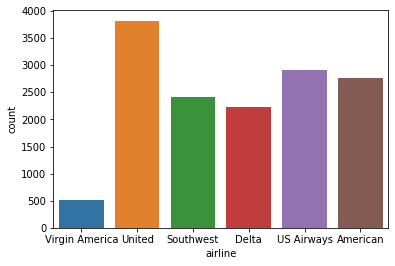

In [11]:
# Distribution of Airline Tweets
sns.countplot(data.airline)

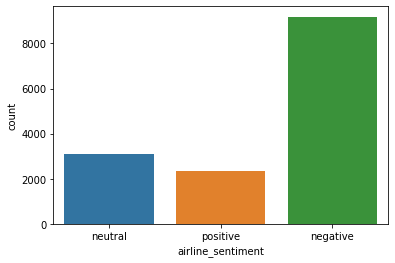

In [12]:
# Distribution of Tweets
sns.countplot(data.airline_sentiment)

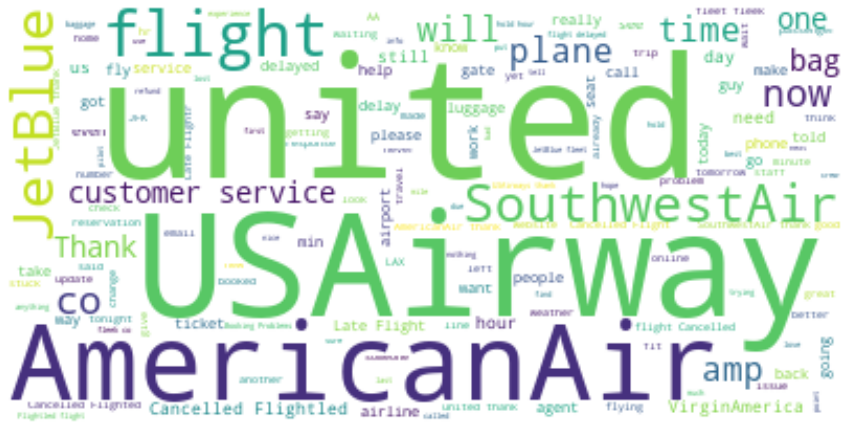

In [14]:
text = ''.join(tweet for tweet in data.text)
wordcloud = WordCloud(max_font_size=80, max_words=150, background_color="white").generate(text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Converting Classes into numeric values

In [17]:
for i in range(len(data.airline_sentiment)):
  # Neutral as 0 , Positive as 1, Negative as 2
  if data.airline_sentiment.iloc[i] == "neutral":
    data.airline_sentiment.iloc[i] = 0
  if data.airline_sentiment.iloc[i] == "positive":
    data.airline_sentiment.iloc[i] = 1
  else:
    data.airline_sentiment.iloc[i] = 2

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [0]:
data.airline_sentiment = data.airline_sentiment.astype('int64')

**BERT Rquirements**

BERT requires data in a specific format. We will need to format our data in the required format.

1. We need to add special tokens at the start and the end of the sentence.
2. Padded or truncated sentences of constant length. 
3. Differentiate real token from padded tokens with the "Attention Masks". (0 is not assigned to any tokens, Authors of BERT have assigned [PAD] token to id:0 to understand that any other ids are real words and the one with 0 are padded tokens). 

[Sep] tokens

We need to add the seperator token [sep] at the end of every sentence.
(Generally used when input is 2 sentences and BERT needs to understand to seperate them)

[Cls] token

Especially for classification tasks, we need to append [Cls] token in the beginning of every sentence.

BERT consists of 12 transformer layers. Each transformer takes in a list of embeddings and produces same number of embeddings on the output (with changed feature values)

On the output of the final transformer, only the first embedding (corresponding to the [Cls] token) is used by the classifier. All the information about the sentence has to be encoded in the final vector [Cls]


Sentence Length & Attention Mask

Text data may never be of consistant length. Some of the shortcomings of BERT are
1. It restricts the maximum token length to be 512 (sentence length).
2. It requires sentences to be of fixed length and hence requires truncation or padding

[PAD] token (id: 0) used in BERT vocabulary



**Getting data ready for BERT**

1. Splitting the reviews into tokens
2. Adding [Cls] and [Sep] tokens at the start and end of each sentence
3. Mapping the tokens to their IDs


#### Tokenizeing the tweets using the BertTokenizer

In [0]:
tokenizer=BertTokenizer.from_pretrained('bert-base-uncased')
tweet = data.text.values
labels=data.airline_sentiment.values
input_ids = []

for texts in tweet:
    try:
      encoded_text = tokenizer.encode(
      texts, 
      add_special_tokens = True
  )

      input_ids.append(encoded_text)
    
    except: 
        continue

In [38]:
input_ids[0]

[101,
 1030,
 6261,
 14074,
 14735,
 2054,
 1030,
 28144,
 13699,
 8022,
 2056,
 1012,
 102]

#### Checking the average and maximum tweet length of our data. This will help us set the max_length

In [39]:
print( 'Maximum token length: ',max([len(f) for f in input_ids]))
print("Average token length: ", round(np.mean([len(i) for i in input_ids]), 2))

Maximum token length:  67
Average token length:  29.07


#### Padding

In [40]:
max_len = 128
input_ids = pad_sequences( input_ids, maxlen = max_len, dtype = 'long', value = 0, truncating = 'post', padding = 'post')
print( 'Example of a padded sequence: ', input_ids[3])

Example of a padded sequence:  [  101  1030  6261 14074 14735  2009  1005  1055  2428  9376  2000  8479
 27885  3630 25171  1000  4024  1000  1999  2115  6368  1005  5344  1004
 23713  1025  2027  2031  2210 28667 22957  2063   102     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]


#### Attention Masks

In [0]:
attention_masks = []

for tweet in input_ids:
  att_mask = [int(token_id) > 0 for token_id in tweet]
  attention_masks.append(att_mask)

#### Splitting our data into Training, Testing and Validation Set

In [42]:
from sklearn.model_selection import train_test_split
#14640 - total dataset
# train : validation : test = 10000 : 2000: 4640
# train_masks : validation_masks = 10000 : 2000

train_x = input_ids[:10000]
test_x = input_ids[10000:]

train_y = labels[:10000]
test_y = labels[10000:]

# x_test.shape, y_test.shape

#Train set, Validation set
x_train, x_val, y_train, y_val = train_test_split(train_x, train_y, test_size = 0.2, random_state = 1000)

# print(x_train.shape, y_train.shape)

# #Train Masks, Validation Masks
attention_mask_train = attention_masks[:10000]
train_masks, val_masks, _, _ = train_test_split(attention_mask_train, train_y, test_size = 0.2, random_state = 1000)

print(len(train_masks), len(val_masks))
# val_x.shape, val_y.shape
# train_masks.shape, val_masks

8000 2000


#### Converting into Pytorch data types

Since BERT is developed in pytorch, we will need to convert numpy arrays into torch tensors

In [0]:
#Converting data into torch tensors
train_inputs = torch.tensor(x_train)
validation_inputs = torch.tensor(x_val)

train_labels = torch.tensor(y_train)
validation_labels = torch.tensor(y_val)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(val_masks)

#### Loading the data in batches using DataLoader

In [0]:
# Data will be trained in batches, hence to do this, we will use DataLoader library 
# Batch size needs to be specified, and for BERT advisable batch size is 16 or 32


batch_size = 32

#Creating Dataloader for out training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)

#Creating Dataloader for validation set
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler = validation_sampler, batch_size = batch_size)


#### Configuration of the BERT model for our use case.

We specify the type of model "bert-base-uncased", labels = 3 as we classify into three sentiments (positive, negative, and neutral)

In [45]:
# from transformers import BertForSequenceClassification, AdamW, BertConfig

# configuration of the BERT model for our use case. We specify the type of model "bert-base-uncased", labels = 2 as we clssify into two poles (positive, negative)
model1 = BertForSequenceClassification.from_pretrained("bert-base-uncased", 
                                                       num_labels = 3,
                                                       output_attentions = False,
                                                       output_hidden_states = False)

In [46]:
model1.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

#### AdamW Optimizer 

It is used to set the rules for updating our weights. we set the learning rate to 2e-5 so that we do not converge too quickly.

In [0]:
optimizer = AdamW(model1.parameters(), 
                  lr = 3e-5)

In [0]:
# Linear scheduler is used for learning rate decay
epochs = 4
steps = len( train_dataloader ) * epochs
scheduler = get_linear_schedule_with_warmup( optimizer, num_warmup_steps=0, num_training_steps= steps)

In [0]:
#Defining a helper function to evaluate our model.
def accuracy(predictions, labels):
  """This function returns the model accuracy """
  pred_flat =  np.argmax(predictions, axis = 1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat == labels_flat) / len(labels_flat)

#### Training Loop borrowed from the Huggingface Library!

In [50]:

seed_val = 42

random.seed( seed_val )
np.random.seed( seed_val )
torch.manual_seed ( seed_val )
torch.cuda.manual_seed( seed_val )

# Storing loss values to plot loss curves

loss_list = []

# For 4 epochs

for epoch in range(epochs):
  print('Epoch ', epoch)

  start = time.time()

  total_loss = 0

  model1.train()

  for step, batch in enumerate(train_dataloader):

    # Data is read from dataloader object
    # Data is of three types, input ids, attention masks and labels in the respective orders
    # This data has to be stored on the gpu

    b_input_ids = batch[0].to(device)
    b_attn_masks = batch[1].to(device)
    b_labels = batch[2].to(device)

    #Reset gradient to zero

    model1.zero_grad()

    # Run the model

    result = model1( b_input_ids, attention_mask = b_attn_masks, labels = b_labels)

    #Output is obtained as a tuple

    loss = result[0]
    total_loss += loss.item()

    #Backward pass

    loss.backward()

    # Update optimizer

    optimizer.step()
    scheduler.step()

  avg_loss = total_loss / len(train_dataloader)
  loss_list.append(avg_loss)

  print('Average training loss: ', avg_loss)
  print('Time required: ',time.time()-start )


  #Running the validation set

  print('Running validation')

  start = time.time()

  model1.eval()

  eval_loss, eval_accuracy = 0,0
  batches = 0

  for step, batch in enumerate(validation_dataloader):

    # Data is read from dataloader object
    # Data is of three types, input ids, attention masks and labels in the respective orders
    # This data has to be stored on the gpu

    b_input_ids = batch[0].to(device)
    b_attn_masks = batch[1].to(device)
    b_labels = batch[2].to(device)

    #Do not calculate gradient since this is validation step, saves computation time

    with torch.no_grad():

      # Run the model
      # As labels are not provided, model returns labels instead of loss function

      result = model1( b_input_ids, attention_mask = b_attn_masks)

      #Output is obtained as a tuple
      # Logits are the final layer outputs without the activation function
      logits = result[0]

      # Extracting these logits from gpu to cpu

      logits = logits.detach().cpu().numpy()
      labels = b_labels.to('cpu').numpy()

      #Calculate cross-validation accuracy

      tmp_eval_accuracy = accuracy( logits, labels)
      eval_accuracy += tmp_eval_accuracy
      batches += 1

  print( 'Cross valiadtion accuracy is: ', eval_accuracy/batches)
  print(' Validation time: ', time.time() - start)

print('Training done')

Epoch  0
Average training loss:  0.2722433574050665
Time required:  178.9734480381012
Running validation
Cross valiadtion accuracy is:  0.9255952380952381
 Validation time:  16.337475538253784
Epoch  1
Average training loss:  0.13623175977170468
Time required:  177.40207481384277
Running validation
Cross valiadtion accuracy is:  0.9280753968253969
 Validation time:  16.333399295806885
Epoch  2
Average training loss:  0.0741948988288641
Time required:  177.15132117271423
Running validation
Cross valiadtion accuracy is:  0.9280753968253969
 Validation time:  16.332804918289185
Epoch  3
Average training loss:  0.041725760370492936
Time required:  177.2793092727661
Running validation
Cross valiadtion accuracy is:  0.9241071428571429
 Validation time:  16.284135103225708
Training done


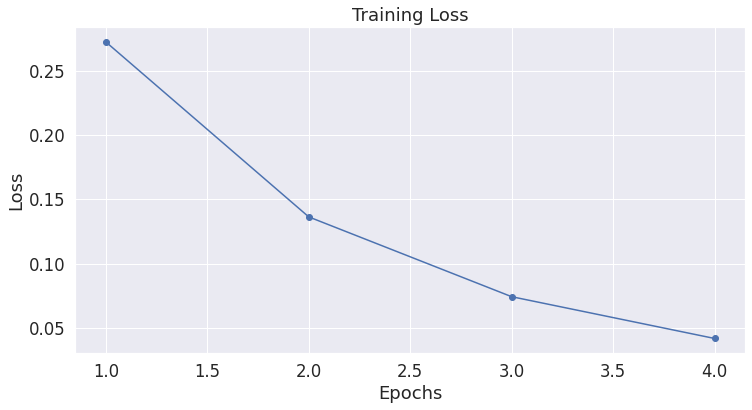

In [51]:
sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)
x=  [f for f in range(1,5)]
y= loss_list
plt.plot(x, y, 'b-o')

plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.show()

#### EDA on Test Set

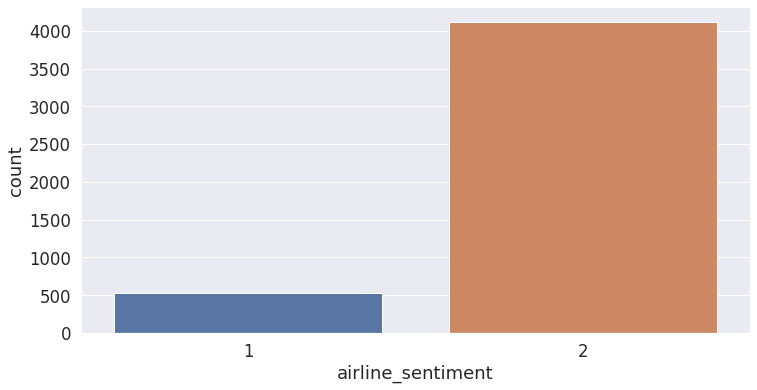

In [55]:
#Checking the distribution of the test set. We need to observe if the test data is balanced or not as based on that we will decide which evaluation metric to use!
sns.countplot(data.airline_sentiment[10000:])

#### Data Preparation

Tokenizing, Padding and creating attention masks for test Tweets

In [72]:
# input_ids_test = []
# for tweet in test_y:
#   encoded = tokenizer.encode(tweet, add_special_tokens = True)
#   input_ids_test.append(encoded)

# input_ids_test = pad_sequences(input_ids_test, maxlen = maxlen, dtype = 'long', truncating = 'post')

# attention_mask_test = []

# for seq in input_ids_test:
#   seq_mask = [float(i>0) for i in seq]
#   attention_mask_test.append(seq_mask)

input_ids_test = test_x
attention_mask_test = attention_masks[10000:]

print(len(input_ids_test), len(attention_mask_test), len(test_y))

print(input_ids_test)

4640 4640 4640
[[  101  1030  3915 ...     0     0     0]
 [  101  1030  3915 ...     0     0     0]
 [  101  1030  3915 ...     0     0     0]
 ...
 [  101  1030 25988 ...     0     0     0]
 [  101  1030 25988 ...     0     0     0]
 [  101  1030 25988 ...     0     0     0]]


In [0]:
#Creating torch tensors and DataLoader
prediction_inputs = torch.tensor(input_ids_test)
prediction_masks = torch.tensor(attention_mask_test)
prediction_labels = torch.tensor(test_y)

batch_size = 32

prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels )
prediction_sampler  = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler= prediction_sampler, batch_size = batch_size)

#### Evaluating on test set

In [75]:
model1.eval()

predictions, true_labels = [], []

for batch in prediction_dataloader:

  b_input_ids = batch[0].to(device)
  b_attn_masks = batch[1].to(device)
  b_labels = batch[2].to(device)

  # batch = tuple(t.to(device) for t in batch)

  # b_input_ids, b_input_masks, b_labels =  batch

  with torch.no_grad():
    outputs = model1(b_input_ids, token_type_ids = None, attention_mask = b_attn_masks)

  logits = outputs[0]

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  predictions.append(logits)
  true_labels.append(label_ids)

print("Done with Test Evaluation ")

Done with Test Evaluation 


#### Compute the Matthews correlation coefficient (MCC)

The Matthews correlation coefficient is used in machine learning as a measure of the quality of binary and multiclass classifications. It takes into account true and false positives and negatives and is generally regarded as a balanced measure which can be used even if the classes are of very different sizes. The MCC is in essence a correlation coefficient value between -1 and +1. A coefficient of +1 represents a perfect prediction, 0 an average random prediction and -1 an inverse prediction. The statistic is also known as the phi coefficient.

Source: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html

In [78]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

print("Calculating Matt..Coeff.. for each batch")

for b in range(len(true_labels)):

  pred_labels_i = np.argmax(predictions[b], axis = 1).flatten()

  matthews = matthews_corrcoef(true_labels[b], pred_labels_i)
  matthews_set.append(matthews)

Calculating Matt..Coeff.. for each batch


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [80]:
# Variation of performance over the batches!
matthews_set

[1.0,
 0.0,
 1.0,
 1.0,
 0.8027729719194864,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.8509629433967631,
 0.5584155773160767,
 0.8132500607904443,
 0.8171428571428572,
 0.8509629433967631,
 1.0,
 1.0,
 1.0,
 0.7474093186836597,
 0.8783100656536799,
 0.8027729719194864,
 1.0,
 1.0,
 1.0,
 0.9165151389911681,
 1.0,
 1.0,
 0.4666666666666667,
 0.6695340634119862,
 0.0,
 0.7948717948717948,
 0.762962962962963,
 0.6,
 0.0,
 0.8958064164776167,
 0.8958064164776167,
 0.0,
 0.3578300267477955,
 0.9078412990032037,
 1.0,
 0.42857142857142855,
 1.0,
 0.6180700462007377,
 0.8509629433967631,
 0.8027729719194864,
 0.8027729719194864,
 0.7867957924694432,
 0.6831300510639733,
 0.8454106280193237,
 0.8027729719194864,
 0.4857142857142857,
 1.0,
 0.7142857142857143,
 0.52678658400752,
 0.6831300510639733,
 0.4666666666666667,
 0.6180700462007377,
 0.6342857142857142,
 0.7419408268023742,
 0.8132500607904443,
 0.6666666666666666,
 0.7142857142857143,
 0.9078412990032037,
 0.8320502943378436,
 0.907

Text(0.5, 1.0, 'MCC Score across all Batches')

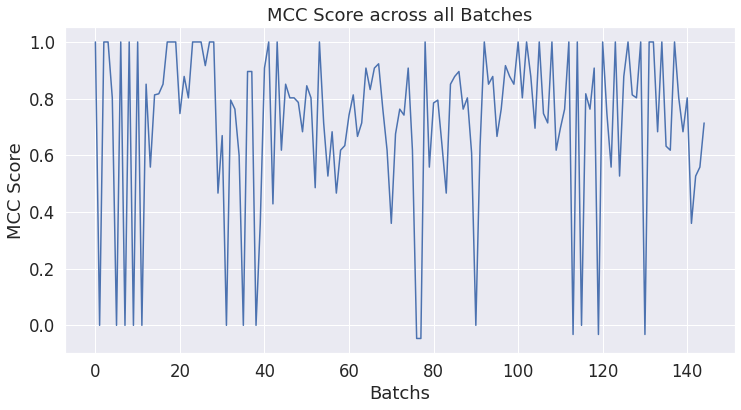

In [91]:
sns.lineplot(x= [i for i in range(len(matthews_set))], y= matthews_set)
plt.xlabel("Batchs")
plt.ylabel("MCC Score")
plt.title("MCC Score across all Batches")

In [86]:
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis = 1).flatten()

flat_true_values = [item for sublist in true_labels for item in sublist]

mcc= matthews_corrcoef(flat_true_values, flat_predictions)

print("MCC on the Test Set: ", mcc )

MCC on the Test Set:  0.7740833517149727


#### Summary and To do list:

**Summary**

BERT :

This breakthrough was the result of Google research on transformers: models that process words in relation to all the other words in a sentence, rather than one-by-one in order. BERT models can therefore consider the full context of a word by looking at the words that come before and after it—particularly useful for understanding the intent behind search queries.

A coefficient of +1 represents a perfect prediction, 0 an average random prediction and -1 an inverse prediction. We have achieved an MCC score of 0.77, which is a decent number given the amount of traing data we had. With some hyperparameter tuning, we can expect better results. However, these are some of the next steps which I plan to follow to extend this project work!


**Next Steps** 
1. Hyper-parameter tuning

 (a) Fine tuning for more number of epochs
 (b) Changing the batch size may speed up the process, would it alter the performance?

2. Using BERT for text classifications for token lengths > 512 to compare results (on the Yelp Dataset)
3. Exploring other architectures like XLNET, RoBERTa to compare their performance with BERT
